In [1]:
# This is the initial take of pulling the MNIST CBIR from https://blog.sicara.com/keras-tutorial-content-based-image-retrieval-convolutional-denoising-autoencoder-dc91450cc511
#    and making it work in a Jupyter notebook for unrotated pill images.



In [1]:
import keras
keras.__version__

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.2'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7845978109441930549
]


In [3]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [4]:
from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

## Train model

In [5]:
target_image_size = (52,100)

In [6]:
# Import required items for training
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Dense
from keras.models import Model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import callbacks
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


# For training
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [7]:
# Load the data (in that case MNIST)
train_datagen = ImageDataGenerator(
        shear_range=0.05,
        zoom_range=0.01,
        rotation_range=5.00,
        height_shift_range=0.10,
        width_shift_range=0.10,
        rescale=1. / 255,
        horizontal_flip=False)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        'data_with_rotations/train',
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode='rgb')

validation_generator = validation_datagen.flow_from_directory(
        'data_with_rotations/validate',
        target_size=target_image_size,
        batch_size=32,
        class_mode='input',
        color_mode='rgb')



Found 722 images belonging to 1 classes.
Found 191 images belonging to 1 classes.


Found 96 images belonging to 1 classes.


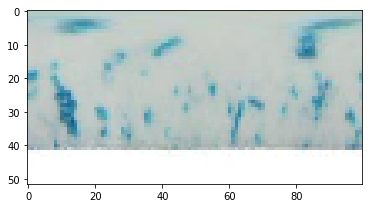

In [8]:
# Get 16 sample images to use throughout all the training for visualization
# Load Test images to generate testing data
sample_datagen = ImageDataGenerator(rescale=1. / 255)

sample_generator = sample_datagen.flow_from_directory(
        'data_with_rotations/test',
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode='rgb')

next_batch = next(sample_generator)
sample_images = next_batch[0]
test_image=sample_images[1]




plt.imshow(test_image)

#plt.show()


In [9]:
def define_model():
    
    big_conv = (7,7)
    num_conv = 128
    
    #Input
    input_img = Input(shape=(52, 100, 3))  # adapt this if using `channels_first` image data format
    
    # Layer 10
    encoded = Conv2D(128, (12,12), activation='relu', padding='same', name='encoder')(input_img)
    #x = Conv2D(128, (10, 10), activation='relu')(encoded)
    
    # Output
    #decoded = Conv2D(3, (1,1), activation='sigmoid', padding='same', name='decoded')(encoded)
    #. Conv2d left with a good image, but a chunk of fuzzyiness
    
    decoded = Dense(3, activation='tanh')(encoded)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    print(autoencoder.outputs)
        
    return autoencoder
    
    #autoencoder.fit_generator(
    #    train_generator,
    #    steps_per_epoch=2000,
    #    epochs=10,
    #    validation_data=validation_generator,
    #    validation_steps=800)
        #callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])
    
    # autoencoder.save('autoencoder_pill.h5')



In [10]:
class ProgressCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        #print('epoch ended')
        #print(self.model)
        
        processed_images = self.model.predict(x=sample_images,batch_size=16)
                
        # plot the image
        f = plt.figure()
        f.add_subplot(1, 2, 1)  # this line outputs images side-by-side
        plt.imshow(sample_images[0])
        f.add_subplot(1, 2, 2)  # this line outputs images side-by-side
        plt.imshow(processed_images[0])
        plt.suptitle('Epoch ' + str(epoch))
        filename = 'epoch-' + str(epoch) + '.png'
        plt.savefig(filename)
        plt.close()
        #plt.show()


In [11]:


def train_model(model_to_train):
    progress = ProgressCallback()
    early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')
    model_to_train.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=50,
        callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False),progress,early_stop])
    
    model_to_train.save('autoencoder_pill4.h5')
    
    return model_to_train

In [12]:
# Train the model
x = define_model()

[<tf.Tensor 'dense_1/Tanh:0' shape=(?, 52, 100, 3) dtype=float32>]


In [13]:
print(x.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 52, 100, 3)        0         
_________________________________________________________________
encoder (Conv2D)             (None, 52, 100, 128)      55424     
_________________________________________________________________
dense_1 (Dense)              (None, 52, 100, 3)        387       
Total params: 55,811
Trainable params: 55,811
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
progress = ProgressCallback()

In [15]:
autoencoder = train_model(x)

Epoch 1/5
200/200 [==============================] - 52s 260ms/step - loss: 0.5781 - val_loss: 0.5093
Epoch 2/5
200/200 [==============================] - 52s 261ms/step - loss: 0.5162 - val_loss: 0.4945
Epoch 3/5
200/200 [==============================] - 54s 269ms/step - loss: 0.5096 - val_loss: 0.4819
Epoch 4/5
200/200 [==============================] - 54s 268ms/step - loss: 0.5037 - val_loss: 0.4915
Epoch 5/5
200/200 [==============================] - 53s 267ms/step - loss: 0.5032 - val_loss: 0.4908


In [129]:
#!pip3 install jupyter-tensorboard
#autoencoder = train_model(x)

Epoch 1/5
200/200 [==============================] - 32s 162ms/step - loss: 0.4926 - val_loss: 0.4736
Epoch 2/5
200/200 [==============================] - 32s 162ms/step - loss: 0.4938 - val_loss: 0.4780
Epoch 3/5
200/200 [==============================] - 32s 160ms/step - loss: 0.4917 - val_loss: 0.4673
Epoch 4/5
200/200 [==============================] - 32s 160ms/step - loss: 0.4918 - val_loss: 0.4747
Epoch 5/5
200/200 [==============================] - 31s 156ms/step - loss: 0.4909 - val_loss: 0.4648


In [123]:
#!tensorboard --logdir=/tmp/tb
#autoencoder = train_model(x) #Results from only 16 convolutions vs 64

## Test the model

In [16]:
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



In [17]:
# Load the model trained above
print('Loading model :')
t0 = time.time()
autoencoder = load_model('autoencoder_pill4.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
t1 = time.time()
print('Model loaded in: ', t1-t0)

scores = []

Loading model :
Model loaded in:  0.4177680015563965


In [18]:
# Load Test images to generate testing data
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
        'data_with_rotations/test',
        target_size=(52, 100),
        batch_size=32,
        class_mode='input',
        color_mode='rgb')







Found 96 images belonging to 1 classes.


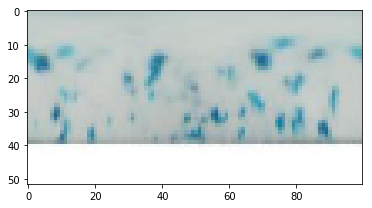

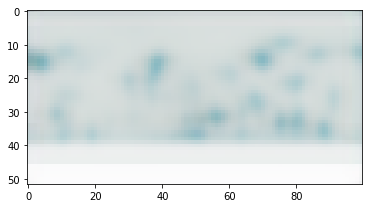

In [19]:
# Let's just view a few input images and output images

next_batch = next(test_generator)
images = next_batch[0]
first_image=images[0]
second_image=images[1]

plt.imshow(first_image)
plt.show()

#plt.imshow(second_image)
#plt.show()

recreated_pill = autoencoder.predict(x=images,batch_size=32)

plt.imshow(recreated_pill[0])
plt.show()

#categories = next_batch[1]
#print(categories[0])

In [135]:
# For confusion matrix, you need two items, y_test and y_pred
#     y_test is the known categorical values of the test set 
#     y_pred is the predicted categorical values of the test set 

# To get y_test we'll use the validation_generator, but let's grab all images
#test_generator.batch_size = 751

nb_batches_to_capture = 1 # batches * batch_size should be less than total number of items available, else repeats will happen

y_true = []
y_pred = []

for index in range(nb_batches_to_capture):
    next_batch = next(test_generator)
    #images = next_batch[0]
    print(images[0])
    categories = next_batch[1]
    #print(categories[0])
    #print(len(categories))
    # To get y_pred, we actually need to predict the categories of the all_images set
    #predicted_categories= model.predict_classes(x=images,batch_size=batch_size)
    #print(len(predicted_categories))
    #if len(categories) == len(predicted_categories):
    #    y_true.extend(categories)
    #    y_pred.extend(predicted_categories)
    #else:
    #    print("Mismatched actual and predicted - ignoring batch")
    
print(len(y_true))
print(len(y_pred))

[[[0.75294125 0.79215693 0.7960785 ]
  [0.75294125 0.79215693 0.7960785 ]
  [0.75294125 0.79215693 0.7960785 ]
  ...
  [0.75294125 0.78823537 0.77647066]
  [0.75294125 0.78823537 0.77647066]
  [0.75294125 0.78823537 0.77647066]]

 [[0.7686275  0.79215693 0.7843138 ]
  [0.7686275  0.79215693 0.7843138 ]
  [0.7686275  0.79215693 0.7843138 ]
  ...
  [0.7568628  0.79215693 0.7803922 ]
  [0.7568628  0.79215693 0.7803922 ]
  [0.7568628  0.79215693 0.7803922 ]]

 [[0.77647066 0.7960785  0.7725491 ]
  [0.77647066 0.7960785  0.7725491 ]
  [0.77647066 0.7960785  0.7725491 ]
  ...
  [0.7607844  0.7960785  0.7843138 ]
  [0.7607844  0.7960785  0.7843138 ]
  [0.7607844  0.7960785  0.7843138 ]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]


In [ ]:
# Create methods for determining closest image
def retrieve_closest_elements(test_code, test_label, learned_codes):
    distances = []
    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    return sorted_distances, sorted_labels, sorted_indexes


def compute_average_precision_score(test_codes, test_labels, learned_codes, n_samples):
    out_labels = []
    out_distances = []
    retrieved_elements_indexes = []
    for i in range(len(test_codes)):
        sorted_distances, sorted_labels, sorted_indexes = retrieve_closest_elements(test_codes[i], test_labels[i], learned_codes)
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])
        retrieved_elements_indexes.append(sorted_indexes[:n_samples])

    out_labels = np.array(out_labels)
    out_labels_file_name = 'computed_data/out_labels_{}'.format(n_samples)
    np.save(out_labels_file_name, out_labels)

    out_distances_file_name = 'computed_data/out_distances_{}'.format(n_samples)
    out_distances = np.array(out_distances)
    np.save(out_distances_file_name, out_distances)
    score = label_ranking_average_precision_score(out_labels, out_distances)
    scores.append(score)
    return score


def retrieve_closest_images(test_element, test_label, n_samples=10):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])

    test_code = encoder.predict(np.array([test_element]))
    test_code = test_code.reshape(test_code.shape[1] * test_code.shape[2] * test_code.shape[3])

    distances = []

    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    kept_indexes = sorted_indexes[:n_samples]

    score = label_ranking_average_precision_score(np.array([sorted_labels[:n_samples]]), np.array([sorted_distances[:n_samples]]))

    print("Average precision ranking score for tested element is {}".format(score))

    original_image = x_test[0]
    cv2.imshow('original_image', original_image)
    retrieved_images = x_train[int(kept_indexes[0]), :]
    for i in range(1, n_samples):
        retrieved_images = np.hstack((retrieved_images, x_train[int(kept_indexes[i]), :]))
    cv2.imshow('Results', retrieved_images)
    #cv2.waitKey(0)

    cv2.imwrite('test_results/original_image.jpg', 255 * cv2.resize(original_image, (0,0), fx=3, fy=3))
    cv2.imwrite('test_results/retrieved_results.jpg', 255 * cv2.resize(retrieved_images, (0,0), fx=2, fy=2))



In [ ]:
# Create methods to test the model
def test_model(n_test_samples, n_train_samples):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0], learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])
    test_codes = encoder.predict(x_test)
    test_codes = test_codes.reshape(test_codes.shape[0], test_codes.shape[1] * test_codes.shape[2] * test_codes.shape[3])
    indexes = np.arange(len(y_test))
    np.random.shuffle(indexes)
    indexes = indexes[:n_test_samples]

    print('Start computing score for {} train samples'.format(n_train_samples))
    t1 = time.time()
    score = compute_average_precision_score(test_codes[indexes], y_test[indexes], learned_codes, n_train_samples)
    t2 = time.time()
    print('Score computed in: ', t2-t1)
    print('Model score:', score)


def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))
    test_img = x_test_noisy[0]
    resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[0]
    resized_output = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)
    cv2.imwrite('test_results/noisy_image.jpg', 255 * resized_test_img)
    cv2.imwrite('test_results/denoised_image.jpg', 255 * resized_output)


In [ ]:

# To test the whole model
n_test_samples = 100
#n_train_samples = [10, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000,
#                   20000, 30000, 40000, 50000, 60000]

n_train_samples = [10]

for n_train_sample in n_train_samples:
    test_model(n_test_samples, n_train_sample)








In [ ]:
# Save model
np.save('computed_data/scores', np.array(scores))

In [ ]:
# To retrieve closest image
retrieve_closest_images(x_test[0], y_test[0])


In [ ]:

# To plot a denoised image
plot_denoised_images()

In [ ]:
print('hello')